<a href="https://colab.research.google.com/github/niranjantdesai/bayesian-learning/blob/master/bayes_by_backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://github.com/ThirstyScholar/bayes-by-backprop

In [0]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [0]:
class BNNLayer(nn.Module):
    NegHalfLog2PI = -.5 * math.log(2.0 * math.pi)
    softplus = lambda x: math.log(1 + math.exp(x))

    def __init__(self, n_input, n_output, activation, prior_mean, prior_rho):
        assert activation in {'relu', 'softmax', 'none'}, 'Activation Type Not Found'

        super(BNNLayer, self).__init__()

        # Instantiate a large Gaussian block to sample from, much faster than generating random sample every time
        self._gaussian_block = np.random.randn(10000)

        self.n_input = n_input
        self.n_output = n_output

        self.W_mean = nn.Parameter(torch.ones((n_input, n_output)) * prior_mean)
        self.W_rho = nn.Parameter(torch.ones(n_input, n_output) * prior_rho)

        self.b_mean = nn.Parameter(torch.ones(1, n_output) * prior_mean)
        self.b_rho = nn.Parameter(torch.ones(1, n_output) * prior_rho)

        self.prior_var = Variable(torch.ones(1, 1) * BNNLayer.softplus(prior_rho) ** 2)

        # Set activation function
        self.act = None
        if activation == 'relu':
            self.act = F.relu
        elif activation == 'softmax':
            self.act = F.softmax

        self._Var = lambda x: Variable(torch.from_numpy(x).type(torch.FloatTensor))

    def forward(self, X, mode):
        assert mode in {'forward', 'MAP', 'MC'}, 'BNNLayer Mode Not Found'

        _shape = (X.size()[0], self.n_output)

        # Z: pre-activation. Local reparam. trick is used.
        Z_Mean = torch.mm(X, self.W_mean) + self.b_mean.expand(*_shape)

        if mode == 'MAP': return self.act(Z_Mean) if self.act is not None else Z_Mean

        Z_Std = torch.sqrt(
            torch.mm(torch.pow(X, 2),
                     torch.pow(F.softplus(self.W_rho), 2)) +
            torch.pow(F.softplus(self.b_rho.expand(*_shape)), 2)
        )

        Z_noise = self._random(_shape)
        Z = Z_Mean + Z_Std * Z_noise

        if mode == 'MC': return self.act(Z) if self.act is not None else Z

        # Stddev for the prior
        Prior_Z_Std = torch.sqrt(
            torch.mm(torch.pow(X, 2),
                     self.prior_var.expand(self.n_input, self.n_output)) +
            self.prior_var.expand(*_shape)
        ).detach()

        # KL[posterior(w|D)||prior(w)]
        layer_KL = self.sample_KL(Z,
                                  Z_Mean, Z_Std,
                                  Z_Mean.detach(), Prior_Z_Std)

        out = self.act(Z) if self.act is not None else Z
        return out, layer_KL

    def _random(self, shape):
        Z_noise = np.random.choice(self._gaussian_block, size=shape[0] * shape[1])
        Z_noise = np.expand_dims(Z_noise, axis=1).reshape(*shape)
        return self._Var(Z_noise)

    @staticmethod
    def log_gaussian(x, mean, std):
        return BNNLayer.NegHalfLog2PI - torch.log(std) - .5 * torch.pow(x - mean, 2) / torch.pow(std, 2)

    @staticmethod
    def sample_KL(x, mean1, std1, mean2, std2):
        log_prob1 = BNNLayer.log_gaussian(x, mean1, std1)
        log_prob2 = BNNLayer.log_gaussian(x, mean2, std2)
        return (log_prob1 - log_prob2).sum()

In [0]:
class BNN(nn.Module):
    def __init__(self, *layers):
        super(BNN, self).__init__()

        self.layers, self.params = [], nn.ParameterList()
        for layer in layers:
            self.layers.append(layer)
            self.params.extend([*layer.parameters()])   # register module parameters

    def forward(self, x, mode):
        if mode == 'forward':
            net_kl = 0
            for layer in self.layers:
                x, layer_kl = layer.forward(x, mode)
                net_kl += layer_kl
            return x, net_kl
        else:
            for layer in self.layers:
                x = layer.forward(x, mode)
            return x

    def Forward(self, x, y, n_samples, type):

        assert type in {'Gaussian', 'Softmax'}, 'Likelihood type not found'

        # Sample N samples and average
        total_kl, total_likelh = 0., 0.
        for _ in range(n_samples):
            out, kl = self.forward(x, mode='forward')

            # Gaussian output (with unit var)
            # lklh = torch.log(torch.exp(-(y - out) ** 2 / 2e-2) / math.sqrt(2e-2 * math.pi)).sum()

            if type == 'Gaussian':
                lklh = (-.5 * (y - out) ** 2).sum()
            else:   # softmax
                lklh = torch.log(out.gather(1, y)).sum()

            total_kl += kl
            total_likelh += lklh

        return total_kl / n_samples, total_likelh / n_samples

    @staticmethod
    def loss_fn(kl, lklh, n_batch):
        return (kl / n_batch - lklh).mean()

In [0]:
plt.style.use('seaborn-paper')

train_size = 20
x = np.random.uniform(-4, 4, size=train_size).reshape((-1, 1))
noise = np.random.normal(0, 3, size=train_size).reshape((-1, 1))
y = x ** 3 + noise

Var = lambda x, dtype=torch.FloatTensor: Variable(torch.from_numpy(x).type(dtype))
X = Var(x)
Y = Var(y)

In [0]:
# Initialize network
bnn = BNN(BNNLayer(1, 256, activation='relu', prior_mean=0, prior_rho=0),
          BNNLayer(256, 256, activation='relu', prior_mean=0, prior_rho=0),
          BNNLayer(256, 1, activation='none', prior_mean=0, prior_rho=0))
# bnn = BNN(BNNLayer(1, 100, activation='relu', prior_mean=0, prior_rho=0),
#               BNNLayer(100, 1, activation='none', prior_mean=0, prior_rho=0))

optim = torch.optim.Adam(bnn.parameters(), lr=1e-1)

Text(0, 0.5, 'Loss')

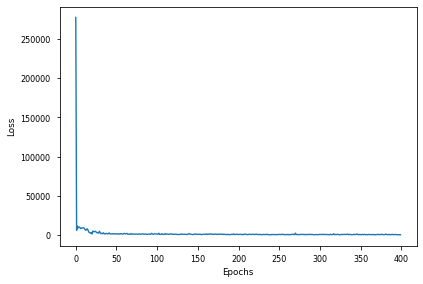

In [32]:
# Main training loop
losses = []
num_epochs = 400
for i_ep in range(num_epochs):
    kl, lg_lklh = bnn.Forward(X, Y, 1, 'Gaussian')
    loss = BNN.loss_fn(kl, lg_lklh, 1)
    losses.append(loss.item())
    optim.zero_grad()
    loss.backward()
    optim.step()
  
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [0]:
# Test data is between -10 and 10.
x_ = np.linspace(0, 1, 100)
x_ = x_ * 20 - 10

# x_ = np.linspace(-5, 5)
y_ = x_ ** 3
X_ = Var(x_).unsqueeze(1)

pred_lst = [bnn.forward(X_, mode='MC').data.numpy().squeeze(1) for _ in range(100)]

pred = np.array(pred_lst).T
pred_mean = pred.mean(axis=1)
pred_std = pred.std(axis=1)

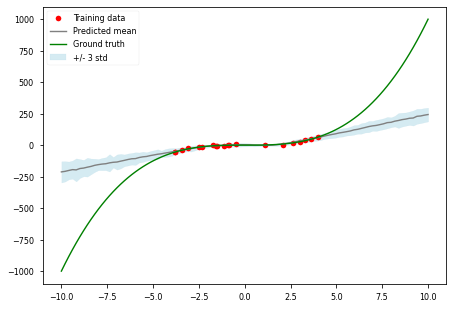

In [39]:
plt.plot(x, y, 'or', label='Training data')
plt.plot(x_, pred_mean, c='grey', label='Predicted mean')
plt.fill_between(x_, pred_mean - 3 * pred_std, pred_mean + 3 * pred_std,
                  color='lightblue', alpha=.5, label='+/- 3 std')

plt.plot(x_, y_, c='green', label='Ground truth')

plt.legend()
plt.tight_layout()
plt.show()